# Student Behaviour Analysis for the Career Advancement and Engagement Department

In [1]:
# Libraries
import pandas as pd
import numpy as np
import plotly as plt
import plotly.express as px
import matplotlib.pyplot as plt
from joypy import joyplot
import os

pd.set_option('display.max_colwidth', None)

In [2]:
# Read in data using pandas
df = pd.read_excel(open('../data/assessment.xlsx', "rb"), #There was 'utf-8' codec start byte error.  Opening in binary mode 
                   sheet_name='Student_Behaviour') #note british spelling of sheet
                   

## Cleaning Data

### Making column names consistent and concise.

In [3]:
# Column Renaming Dictionaries
dictionary = {
    'Certification Course' : "cert_course",
    'Gender' : 'gender',
    'Department': 'department',
    '10th Mark': 'mark_10th',
    '12th Mark': 'mark_12th',
    'college mark': 'mark_college',
    'hobbies': 'hobbies',
    'daily studing time' : 'study_hr_day',
    'prefer to study in': 'study_window',
    'salary expectation': 'salary_expected',
    'Do you like your degree?' : 'degree_happy',
    'willingness to pursue a career based on their degree  ' : 'career_in_degree',
    'social medai & video' : 'social_video_hr_day',
    'Travelling Time ' : 'travel_hr_day',
    'Stress Level ' : 'stress_status',
    'Financial Status' : 'financial_status',
    'part-time job' : 'job_pt'}
df.rename(columns = dictionary,
          inplace=True)

### Ensuring Correct Data Types

In [4]:
# Make job_pt non-bool
df['job_pt'] = df['job_pt'].replace({True: 'Yes', False: 'No'})

# Categorical conversions list
cat_convert = [
        'gender',
        'department',
        'hobbies',
        'study_hr_day',
        'study_window',
        'social_video_hr_day',
        'travel_hr_day',
        'stress_status',
        'financial_status',
        'job_pt',
        'cert_course',
        'degree_happy'
        ]
# Applying conversion lists
df[cat_convert] = df[cat_convert].astype('category')

### Ensuring Correct Labeling of Categorical Data

**Inconsistencies in categorical labels**
- **dept** - `B.com Accounting & Finance ` and `B.com Accounting and Finance ` 
    - standardized and removed trailing spaces
- **hobbies** 
    - fixed caseing of labels
- **`*`_daily** 
    - time buckets addressed to ensure uniformity
    - Relabeled all categories in terms of hours
    - **social_video_hr_day** - Combined `0 Minute` and `1 - 30 Minute` buckets into new `0 to 0.5` to maintain consistency across time buckets
        - 5 students reported 0 minutes
        - 47 students reported 1-30 minutes
- **`*_status`** - Fixed capitalization.

#### Label Map dictionaries

In [5]:
# Manual replacements

# Fixing department labels


In [6]:
# Label Mapping dictionaries
department_mapping= {
    'B.com Accounting and Finance ': 'B.com Accounting & Finance',
    'B.com Accounting & Finance ': 'B.com Accounting & Finance'
}

sentiment_mapping = {
    'awful': 'Awful',
    'bad' : 'Bad',
    'good': 'Good',
    'fabulous': 'Fabulous'
}

study_hr_day_mapping = {
    '0 - 30 minute': '0 to 0.5',
    '30 - 60 minute': '0.5 to 1',
    '1 - 2 Hour': '1 to 2',
    '2 - 3 hour': '2 to 3',
    '3 - 4 hour': '3 to 4',
    'More Than 4 hour': '4+'
}

social_video_hr_day_mapping = {
    '0 Minute': '0 to 0.5',
    '1 - 30 Minute': '0 to 0.5',
    '30 - 60 Minute': '0.5 to 1',
    '1 - 1.30 hour': '1 to 1.5',
    '1.30 - 2 hour': '1.5 to 2',
    'More than 2 hour': '2+'
}

travel_hr_day_mapping = {
    '0 - 30 minutes': '0 to 0.5',
    '30 - 60 minutes': '0.5 to 1',
    '1 - 1.30 hour': '1 to 1.5',
    '1.30 - 2 hour': '1.5 to 2',
    '2 - 2.30 hour': '2 to 2.5',
    '2.30 - 3 hour': '2.5 to 3',
    'more than 3 hour': '3+'
}

df['department'] = df['department'].replace(department_mapping)
df['stress_status'] = df['stress_status'].replace(sentiment_mapping)
df['financial_status'] = df['financial_status'].replace(sentiment_mapping)
df['study_hr_day'] = df['study_hr_day'].replace(study_hr_day_mapping)
df['social_video_hr_day'] = df['social_video_hr_day'].replace(social_video_hr_day_mapping)
df['travel_hr_day'] = df['travel_hr_day'].replace(travel_hr_day_mapping)

#### Ordering Categories

In [7]:
# Setting Categorical Order
# Creating ordered categories
ordered_cats = {
    'stress_status': list(sentiment_mapping.values()),
    'financial_status': list(sentiment_mapping.values()),
    'study_hr_day': list(study_hr_day_mapping.values()),
    # Hardcoded due to duplicate values in dictionary
    'social_video_hr_day': ['0 to 0.5', '0.5 to 1', '1 to 1.5', '1.5 to 2', '2+'],
    'travel_hr_day': list(travel_hr_day_mapping.values())
}

# Applying ordered categories
for col, cats in ordered_cats.items():
    df[col] = df[col].astype(pd.CategoricalDtype(categories=cats, ordered=True))
 

In [8]:
# Categorical Labels
unique_values_df = pd.DataFrame([(col, df[col].unique().tolist()) for col in df.select_dtypes('category').columns],
                                columns=['Category', 'Labels'])
unique_values_df

,Category,Labels
0,cert_course,"[No, Yes]"
1,gender,"[Male, Female]"
2,department,"[BCA, B.com ISM, Commerce, B.com Accounting & Finance]"
3,hobbies,"[Sports, Video game, Video Games, Cinema, Reading books]"
4,study_hr_day,"[1 to 2, 0 to 0.5, 4+, 3 to 4, 0.5 to 1, 2 to 3]"
5,study_window,"[Morning, Anytime, Night]"
6,degree_happy,"[No, Yes]"
7,social_video_hr_day,"[1 to 1.5, 1.5 to 2, 0 to 0.5, 0.5 to 1, 2+]"
8,travel_hr_day,"[0.5 to 1, 0 to 0.5, 3+, 1 to 1.5, 2 to 2.5, 1.5 to 2, 2.5 to 3]"
9,stress_status,"[Good, Awful, Bad, Fabulous]"


In [9]:
# checking data types and missing values
df_info = pd.DataFrame({
    "data_type": df.dtypes,
    "total_values": df.count(),
    "unique_values": df.nunique(),
    "missing_values": df.isnull().sum()
    })
df_info

,data_type,total_values,unique_values,missing_values
cert_course,category,235,2,0
gender,category,235,2,0
department,category,235,4,0
mark_10th,float64,235,68,0
mark_12th,float64,235,67,0
mark_college,float64,235,39,0
hobbies,category,235,5,0
study_hr_day,category,235,6,0
study_window,category,235,3,0
salary_expected,int64,235,84,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   cert_course          235 non-null    category
 1   gender               235 non-null    category
 2   department           235 non-null    category
 3   mark_10th            235 non-null    float64 
 4   mark_12th            235 non-null    float64 
 5   mark_college         235 non-null    float64 
 6   hobbies              235 non-null    category
 7   study_hr_day         235 non-null    category
 8   study_window         235 non-null    category
 9   salary_expected      235 non-null    int64   
 10  degree_happy         235 non-null    category
 11  career_in_degree     235 non-null    float64 
 12  social_video_hr_day  235 non-null    category
 13  travel_hr_day        235 non-null    category
 14  stress_status        235 non-null    category
 15  financial_status     23

# Code Questions

_________________
## 1) Salary Expectations:
> Show Median and Average Salary expectations by department
__________

**Salary Notes**
- Mean and Median salary expectations seem to be good indicators of central tendency for all departments.  Visualizing both for all departments produces box charts that are hard to distinguish.  **However, there is an extreme outlier in BCA that needs to be handled.**
$$ Z = \frac{{x - \mu}}{{\sigma}} = \frac{{130000.0 - 60283.333333}}{{6708.228588}} = 10.39271 $$

In [11]:
# Salary Expectations Descriptives
df.groupby('department')['salary_expected'].describe()

,count,mean,std,min,25%,50%,75%,max
department,,,,,,,,
B.com Accounting & Finance,15.0,60293.333333,2877.614753,55600.0,57950.0,60500.0,62500.0,64500.0
B.com ISM,28.0,59835.714286,2668.362556,55100.0,57975.0,59700.0,62075.0,64500.0
BCA,132.0,60283.333333,6708.228588,55100.0,57450.0,59750.0,62225.0,130000.0
Commerce,60.0,59863.333333,2399.997646,55500.0,57700.0,59650.0,61325.0,64300.0


<Figure size 640x480 with 0 Axes>

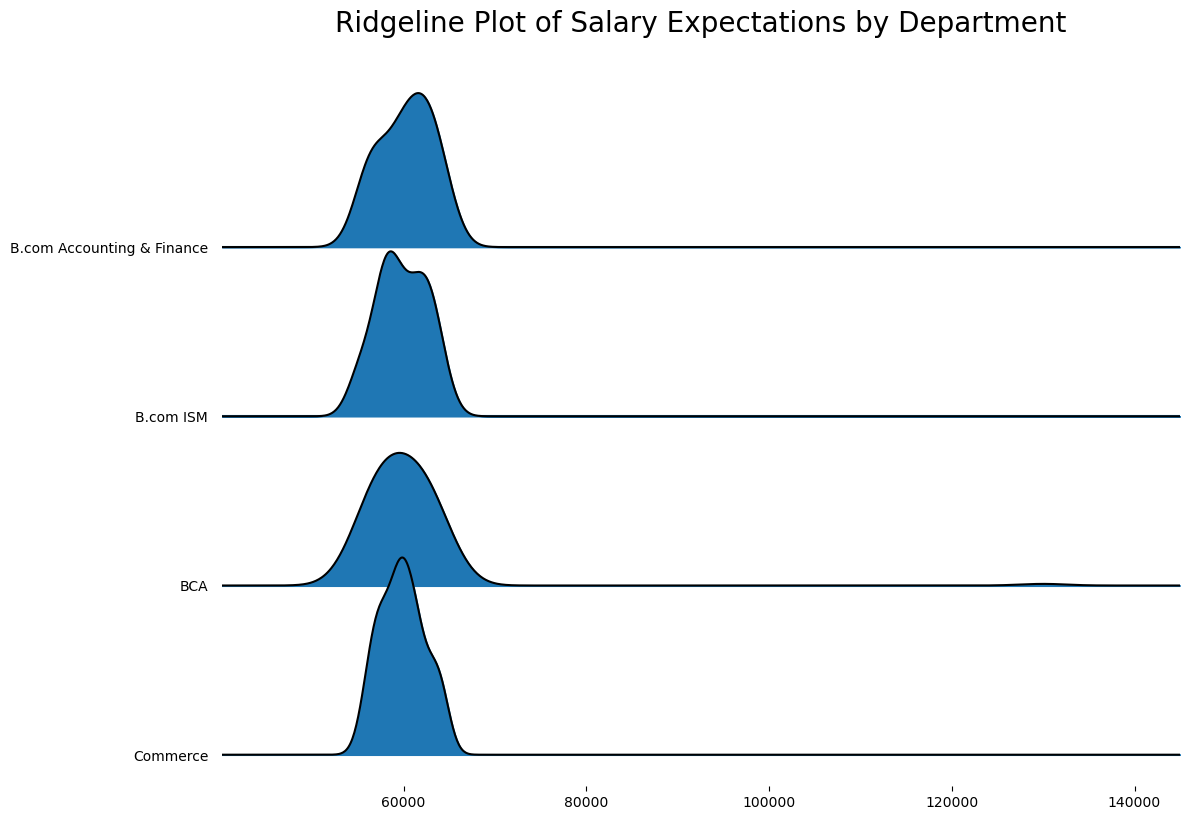

In [12]:
# Salary Ridgeline
plt.figure()
joyplot(
    data=df[['salary_expected', 'department']],
    by='department',
    figsize=(12, 8)
)
plt.title('Ridgeline Plot of Salary Expectations by Department', fontsize=20)
plt.show()

In [20]:
# JUST FIX THE AXIS RANGE SPECIFICALLY FOR Y- DONT SUPPRESS
# Add overall mean as fixed line.  control for extreme outlier in calculation

In [41]:
# Salary Expectations Box Plot
fig = px.box(
    df, 
    x='department', 
    y='salary_expected',
    title='Distribution of Salary Expectations by Department',
    labels={'salary_expected': 'Salary Expected', 'department': 'Department'}
)

# Calculate the overall mean, excluding values over 70,000
overall_mean = df[df['salary_expected'] <= 70000]['salary_expected'].mean()

# Update layout for better readability
fig.update_layout(
    xaxis_title='Department',
    yaxis_title='Expected Salary',
    margin=dict(l=20, r=20, t=60, b=20),
    yaxis=dict(range=[55000, 65000]),  # Set y-axis limits,
    title={
        'text': 'Distribution of Salary Expectations by Department',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)
# Add a line for the overall mean
fig.add_shape(
    type='line',
    y0=overall_mean,
    y1=overall_mean,
    x0=-0.5,
    x1=4.5,
    line=dict(
        color='red',
        width=1,
        dash='dash'
    )
)
# Show the plot
fig.show()

In [14]:
# Calculate mean and median of salary_expected grouped by department
grouped_salary = df.groupby('department')['salary_expected'].agg(['mean', 'median']).reset_index()

# Calculate the overall median of salary_expected
overall_median = df['salary_expected'].median()

# Calculate the difference from the overall median
grouped_salary['diff_mean'] = grouped_salary['mean'] - overall_median
grouped_salary['diff_median'] = grouped_salary['median'] - overall_median

# Melt the dataframe to have the measure type (diff_mean/diff_median) as a separate column
melted_salary = pd.melt(grouped_salary, id_vars='department', value_vars=['diff_mean', 'diff_median'],
                        var_name='measure_type', value_name='salary_diff')

# Create a bar chart with Plotly Express
fig = px.bar(
    melted_salary,
    x='department',
    y='salary_diff',
    color='measure_type',
    title='Difference from Overall Median Salary Expectation by Department',
    labels={'salary_diff': 'Difference from Overall Median', 'department': 'Department'},
    barmode='group'
)

# Customize the layout
fig.update_layout(
    xaxis_title='Department',
    yaxis_title='Difference from Overall Median',
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1
)

# Show the plot
fig.show()

## Degree Satisfaction by Department:
> Display the distribution of 'Do you like your degree?' across different departments


In [15]:
# Create a pie chart for degree_happy with faceting on department
df_pie = df
fig = px.pie(
    df_pie, 
    names='degree_happy',
    title='Distribution of "degree_happy" by Department',
    facet_col='department',
    color_discrete_sequence=['skyblue', 'orange']
)
# Show the plot
fig.show()

Do grouped barchart by department.  Bars will be happiness levels.  Could also do stacked.  Need more EDA.

In [16]:
# Sentiment sunburst

# Create a copy to avoid changing the original data
df_sunburst = df

# Map the boolean values and other categorical variables to more descriptive strings
df_sunburst['degree_happy'] = df['degree_happy'].map({
    'Yes': 'Degree: Happy', 
    'No': 'Degree: Unhappy'
})

# Mapping for stress_status and financial_status
df_sunburst['stress_status'] = df['stress_status'].map({
    'Good': 'Stress: Good',
    'Awful': 'Stress: Awful',
    'Bad': 'Stress: Bad',
    'Fabulous': 'Stress: Fabulous'
})

df_sunburst['financial_status'] = df['financial_status'].map({
    'Good': 'Finances: Good',
    'Awful': 'Finances: Awful',
    'Bad': 'Finances: Bad',
    'Fabulous': 'Finances: Fabulous'
})

# Create a sunburst plot with Plotly Express
fig = px.sunburst(
    df_sunburst, 
    path=['degree_happy', 'stress_status', 'financial_status'], 
    title="Degree Satisfaction, Stress, and Financial Status by Department"
)

# Update layout for better readability
fig.update_layout(
    margin=dict(t=0, b=0, r=0, l=0),
)

# Show the plot
fig.show()

#path=['department', 'degree_happy', 'stress_status', 'financial_status']

## Hobbies and Part-time Jobs:
>  Visualize the percentage of candidates with a 'part-time job' based on their hobbies


## Financial Status and Part-time Jobs:
>  Display the distribution of 'Financial Status' and the percentage of candidates with a 'part-time job'


## Degree Satisfaction:
>  Show the percentage of candidates who like their degree and are willing to pursue a career based on their degree


## Department-wise Analysis:
>  Compare the average '10th Mark', '12th Mark', and 'college mark' for different departments

## *BONUS
> **Supplementing** the provided prompts, include any **additional charts** or **visualizations** that shed light on their *inclination to pursue a career aligned with their degree* and their *level of satisfaction with the chosen degree*

In [17]:
#df.to_parquet('../data/behavior.parquet')

#df.to_csv('../data/behavior.csv', index=False)

In [ ]:
## Keep to the basics.  Funky stuff can be fun, but stick with basics.
############# use bubble plot if there's time for funk
## Get data in good shape.